# Perspective Shift Identification

### Goal: 
Use ML to identify perspective shift in movement of distribution centers

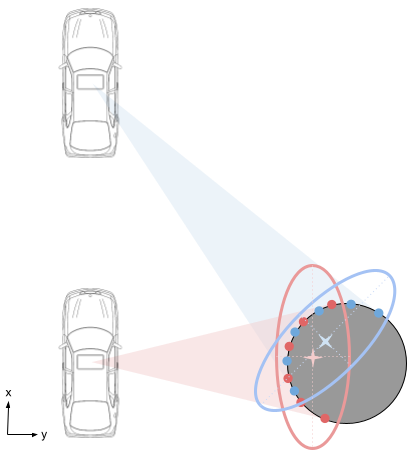

### Assumptions:
Gross rotation and translation have already been estimated by previous scan matching iterations

### Network structure:
Inputs: 
xyz of 25 points randomly sampled from each distribution

Output:
Correction factor translation between the two centers



### Training data generation

(starting with toy example)

1- generate grid of simple shapes in Inventor

2- Rotate randomly, translate randomly and simulate lidar scan of shapes at 2 points in time using MatLab script

3- Sample N points from each object and save to file. Also store information on rotation and translation to seperate file

4- import data here and augment again by duplicating and scaling examples arbitrarily

## TODO

Design test network that can guess the direction of ambiguity

    Use LUT as y_train, Try ULUT

Scale allowable error threshold between DNN and D2D by radial disatance from origin


NOTE: py39 env needed with new GPU setup
https://www.tensorflow.org/install/source#gpu


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime
# import tensorflow_graphics as tfg
# import tensorflow_graphics.nn.layer.pointnet

#need to have these two lines to work on my ancient 1060 3gb
#  https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)

print(tf.__version__) #requires tensorflow 2.3

# %matplotlib inline
# plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'
%matplotlib notebook

%load_ext tensorboard

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
%autosave 180

2022-09-25 22:24:51.480613: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-25 22:24:51.572495: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-25 22:24:51.885179: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-09-25 22:24:51.885218: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.10.0


2022-09-25 22:24:52.591765: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-25 22:24:52.610903: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-25 22:24:52.611017: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Autosaving every 180 seconds


In [2]:
#test pointnet layer...
import tensorflow_graphics as tfg
# tfg.nn.layer.pointnet #works in TF2.9 (with CUDNN 8.x)

In [3]:
#define functions to convert between spherical and cartesian coordinate representations
def c2s(pts):
    """ converts points from cartesian coordinates to spherical coordinates """
    r = tf.sqrt(pts[:,0]**2 + pts[:,1]**2 + pts[:,2]**2)
    phi = tf.math.acos(pts[:,2]/r)
    theta = tf.math.atan2(pts[:,1], pts[:,0])

    out = tf.transpose(tf.Variable([r, theta, phi]))
    return(out)
def s2c(pts):
    """converts spherical -> cartesian"""

    x = pts[:,:,0]*tf.math.sin(pts[:,:,2])*tf.math.cos(pts[:,:,1])
    y = pts[:,:,0]*tf.math.sin(pts[:,:,2])*tf.math.sin(pts[:,:,1]) 
    z = pts[:,:,0]*tf.math.cos(pts[:,:,2])

    out = tf.transpose(tf.Variable([x, y, z]))
    # out = tf.Variable([x, y, z])
    return(out)

In [35]:
# old way - non-reduced dimension solution, only feed DNN each point cloud
# #_________________________________________________________________
# #load individual data numpy files
# d1_1 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v1_scan1.npy")
# d2_1 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v1_scan2.npy")
# gt_1 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v1_ground_truth.npy")

# d1_4 = np.load("C:/Users/Derm/Desktop/big/pshift/scan1_300k_50_samples.npy")
# d2_4 = np.load("C:/Users/Derm/Desktop/big/pshift/scan2_300k_50_samples.npy")
# gt_4 = np.load("C:/Users/Derm/Desktop/big/pshift/ground_truth_300k_50_samples.npy")
# gt_4 = gt_4*0.1 #scale to match real-world data (vel-> pos)

# d1_2 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v2_scan1.npy")
# d2_2 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v2_scan2.npy")
# gt_2 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v2_ground_truth.npy")

# d1_3 = np.load("D:/TrainingData/Ford_scan1_50pts_large_displacement.npy")
# d2_3 = np.load("D:/TrainingData/Ford_scan2_50pts_large_displacement.npy")
# gt_3 = np.load("D:/TrainingData/Ford_ground_truth_50pts_large_displacement.npy")

# d1_5 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v3_scan1.npy")
# d2_5 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v3_scan2.npy")
# gt_5 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v3_ground_truth.npy")

d1 = np.load("/media/derm/06EF-127D/TrainingData/KITTI_scan1_50pts.npy")
d2 = np.load("/media/derm/06EF-127D/TrainingData/KITTI_scan2_50pts.npy")
gt = np.load("/media/derm/06EF-127D/TrainingData/KITTI_ground_truth_50pts.npy")
d1_2 = np.load("/media/derm/06EF-127D/TrainingData/CODD_scan1_50pts.npy")
d2_2 = np.load("/media/derm/06EF-127D/TrainingData/CODD_scan2_50pts.npy")
gt_2 = np.load("/media/derm/06EF-127D/TrainingData/CODD_ground_truth_50pts.npy")

# d1 = np.append(d1_1, d1_4, axis = 0)
# d2 = np.append(d2_1, d2_4, axis = 0)
# gt = np.append(gt_1, gt_4, axis = 0)

# d1 = np.append(d1, d1_3, axis = 0)
# d2 = np.append(d2, d2_3, axis = 0)
# gt = np.append(gt, gt_3, axis = 0)

# d1 = np.load("D:/TrainingData/CODD_v1_scan1_50pts.npy")
# d2 = np.load("D:/TrainingData/CODD_v1_scan2_50pts.npy")
# gt = np.load("D:/TrainingData/CODD_v1_ground_truth_50pts.npy")
# d1_2 = np.load("D:/TrainingData/CODD_v2_scan1_50pts.npy")
# d2_2 = np.load("D:/TrainingData/CODD_v2_scan2_50pts.npy")
# gt_2 = np.load("D:/TrainingData/CODD_v2_ground_truth_50pts.npy")
d1 = np.append(d1, d1_2, axis = 0)
d2 = np.append(d2, d2_2, axis = 0)
gt = np.append(gt, gt_2, axis = 0)

# d1 = np.append(d1, d1_5, axis = 0)
# d2 = np.append(d2, d2_5, axis = 0)
# gt = np.append(gt, gt_5, axis = 0)
# #_________________________________________________________________

# small
# d1 = np.loadtxt("training_data/ICET_Ford_scan1.txt")
# d2 = np.loadtxt("training_data/ICET_Ford_scan2.txt")
# gt = np.loadtxt("training_data/ICET_Ford_ground_truth.txt")

#big
# d1 = np.load("D:/TrainingData/Ford_scan1_50pts_large_displacement.npy")
# d2 = np.load("D:/TrainingData/Ford_scan2_50pts_large_displacement.npy")
# gt = np.load("D:/TrainingData/Ford_ground_truth_50pts_large_displacement.npy")
# d1 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v2_scan1.npy")
# d2 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v2_scan2.npy")
# gt = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v2_ground_truth.npy")
# d1 = np.load("C:/Users/Derm/Desktop/big/pshift/scan1_300k_50_samples.npy")
# d2 = np.load("C:/Users/Derm/Desktop/big/pshift/scan2_300k_50_samples.npy")
# gt = np.load("C:/Users/Derm/Desktop/big/pshift/ground_truth_300k_50_samples.npy")
# gt = gt*0.1 #scale to match real-world data (vel-> pos)
# d1 = np.load("D:/TrainingData/CODD_v1_scan1_50pts.npy")
# d2 = np.load("D:/TrainingData/CODD_v1_scan2_50pts.npy")
# gt = np.load("D:/TrainingData/CODD_v1_ground_truth_50pts.npy")
# d1 = np.load("D:/TrainingData/CODD_v2_scan1_50pts.npy")
# d2 = np.load("D:/TrainingData/CODD_v2_scan2_50pts.npy")
# gt = np.load("D:/TrainingData/CODD_v2_ground_truth_50pts.npy")

# d1 = np.load("/media/derm/06EF-127D/TrainingData/KITTI_scan1_50pts.npy")
# d2 = np.load("/media/derm/06EF-127D/TrainingData/KITTI_scan2_50pts.npy")
# gt = np.load("/media/derm/06EF-127D/TrainingData/KITTI_ground_truth_50pts.npy")
# d1 = np.load("/media/derm/06EF-127D/TrainingData/CODD_scan1_50pts.npy")
# d2 = np.load("/media/derm/06EF-127D/TrainingData/CODD_scan2_50pts.npy")
# gt = np.load("/media/derm/06EF-127D/TrainingData/CODD_ground_truth_50pts.npy")


#100 pts per scan
# d1 = np.load("D:/TrainingData/Ford_scan1_100pts.npy")
# d2 = np.load("D:/TrainingData/Ford_scan2_100pts.npy")
# gt = np.load("D:/TrainingData/Ford_ground_truth_100pts.npy")
# d1 = np.load("D:/TrainingData/KITTI_scan1_100pts.npy")
# d2 = np.load("D:/TrainingData/KITTI_scan2_100pts.npy")
# gt = np.load("D:/TrainingData/KITTI_ground_truth_100pts.npy")
# d1 = np.load("D:/TrainingData/Ford_scan1_100pts_large_displacement.npy")
# d2 = np.load("D:/TrainingData/Ford_scan2_100pts_large_displacement.npy")
# gt = np.load("D:/TrainingData/Ford_ground_truth_100pts_large_displacement.npy")
# d1 = np.loadtxt("D:/TrainingData/simulated_scan1_100pts.txt")
# d2 = np.loadtxt("D:/TrainingData/simulated_scan2_100pts.txt")
# gt = np.loadtxt("D:/TrainingData/simulated_ground_truth_100pts.txt")
# gt = gt*0.1 #scale to match real-world data (vel-> pos)

#reshape but don't convert to tensor
points_per_sample = 50 #50          #points sammpled from each voxel
tsplit = 0.95                   #this fraction goes into training

scan1 = np.reshape(d1, [-1, points_per_sample, 3])
scan2 = np.reshape(d2, [-1, points_per_sample, 3])
ntrain = int(tsplit*tf.shape(scan1)[0].numpy())

x_train = np.append(scan1[:ntrain], scan2[:ntrain], axis = 1)
x_test = np.append(scan1[ntrain:], scan2[ntrain:], axis = 1)
print(np.shape(x_train))
# print(np.shape(x_test))

y_train = gt[:ntrain] #for standard training/ test data
y_test = gt[ntrain:]

(413593, 100, 3)


In [ ]:
#Testing new network structure informed by voxel boundaries
#   input both point clouds AND VOXEL BOUNDS to DNN
#_________________________________________________________________
# big
#old
# d1 = np.load("C:/Users/Derm/Desktop/big/pshift/compact_scan1.npy")
# d2 = np.load("C:/Users/Derm/Desktop/big/pshift/compact_scan2.npy")
# gt = np.load("C:/Users/Derm/Desktop/big/pshift/compact_ground_truth.npy")
# LUT = np.load("C:/Users/Derm/Desktop/big/pshift/LUT.npy")
# L = np.load("C:/Users/Derm/Desktop/big/pshift/L.npy")
# U = np.load("C:/Users/Derm/Desktop/big/pshift/U.npy")
# corn = np.load("C:/Users/Derm/Desktop/big/pshift/corn.npy")
d1 = np.load("D:/TrainingData/compact/compact_scan1.npy")
d2 = np.load("D:/TrainingData/compact/compact_scan2.npy")
gt = np.load("D:/TrainingData/compact/compact_ground_truth.npy")
LUT = np.load("D:/TrainingData/compact/LUT.npy")
L = np.load("D:/TrainingData/compact/L.npy")
U = np.load("D:/TrainingData/compact/U.npy")
corn = np.load("D:/TrainingData/compact/corn.npy")

#small
# d1 = np.load('training_data/compact_scan1.npy')
# d2 = np.load('training_data/compact_scan2.npy')
# gt = np.load('training_data/compact_ground_truth.npy')
# LUT = np.load('training_data/LUT.npy') 
# L = np.load('training_data/L.npy')
# U = np.load('training_data/U.npy')
# corn = np.load('training_data/corn.npy')
#_________________________________________________________________

#loop through each element of corn and convert from spherical to cartesian
# print(np.shape(corn))
new_corn = np.transpose(s2c(corn), [1,0,2,])
# print(np.shape(new_corn))

#reshape but don't convert to tensor
points_per_sample = 50          #poitns sammpled from each voxel
tsplit = 0.9 #0.95                   #this fraction goes into training

scan1 = np.reshape(d1, [-1, points_per_sample, 3])
scan2 = np.reshape(d2, [-1, points_per_sample, 3])
ntrain = int(tsplit*tf.shape(scan1)[0].numpy())

x_train = np.append(scan1[:ntrain], scan2[:ntrain], axis = 1)
x_test = np.append(scan1[ntrain:], scan2[ntrain:], axis = 1)

#combine voxel bound to each training example
x_train = np.append(x_train, new_corn[:ntrain], axis = 1)
x_test = np.append(x_test, new_corn[ntrain:], axis = 1)

y_train = gt[:ntrain] #for standard training/ test data
y_test = gt[ntrain:]
# y_train = gt[:ntrain][:,:,0] #when using compact data
# y_test = gt[ntrain:][:,:,0]
LUT_test = tf.convert_to_tensor(LUT)[ntrain:]
LUT = tf.convert_to_tensor(LUT)[:ntrain] #using from file

U = tf.convert_to_tensor(U)[:ntrain]
L = tf.convert_to_tensor(L)[:ntrain]
corn_train = corn[:ntrain]
corn_test = corn[ntrain:]

print(np.shape(x_train))
# print(np.shape(x_test))

In [ ]:
compact = tf.matmul(U, tf.matmul(L, tf.transpose(U, [0,2,1])))#[:ntrain]
print(np.shape(U))
print(np.shape(compact))
print(np.shape(LUT))

In [ ]:
## Rescaling and zero-centing each point cloud
#100 pts per scan
# d1 = np.load("D:/TrainingData/Ford_scan1_100pts.npy")
# d2 = np.load("D:/TrainingData/Ford_scan2_100pts.npy")
# gt = np.load("D:/TrainingData/Ford_ground_truth_100pts.npy")
d1 = np.load("D:/TrainingData/Ford_scan1_100pts_large_displacement.npy")
d2 = np.load("D:/TrainingData/Ford_scan2_100pts_large_displacement.npy")
gt = np.load("D:/TrainingData/Ford_ground_truth_100pts_large_displacement.npy")

#reshape but don't convert to tensor
points_per_sample = 100 #50          #poitns sammpled from each voxel
tsplit = 0.95 #0.95                   #this fraction goes into training

scan1 = np.reshape(d1, [-1, points_per_sample, 3])
scan2 = np.reshape(d2, [-1, points_per_sample, 3])
ntrain = int(tsplit*tf.shape(scan1)[0].numpy())

#center about zero
mu1 = np.mean(scan1, axis = 1)[:, None, :]
scan1 = scan1 - mu1
scan2 = scan2 - mu1

#make unit scale
RMS = np.std(scan1, axis=(1,2))
scan1 = scan1/RMS[:,None,None]

mu2 = np.mean(scan2, axis = 1)[:, None, :]
scan2 = scan2/RMS[:,None,None]
gt = gt/RMS[:,None]

x_train = np.append(scan1[:ntrain], scan2[:ntrain], axis = 1)
x_test = np.append(scan1[ntrain:], scan2[ntrain:], axis = 1)

y_train = gt[:ntrain] #for standard training/ test data
y_test = gt[ntrain:]
# print(np.shape(x_train))

## Create TF dataset to augment data

In [36]:
def augment(points, gt):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float32)
#     points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64) #try this if above doesn't work
    # shuffle points in first point cloud
    points = tf.concat([tf.random.shuffle(points[:50]), tf.random.shuffle(points[50:100]), points[100:]], axis = 0)
#     print(test)
    return points, gt

BATCH_SIZE = 512

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(len(x_train)).map(augment).batch(BATCH_SIZE)
print(train_dataset)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.shuffle(len(x_test)).map(augment).batch(BATCH_SIZE)
print(val_dataset)

<BatchDataset element_spec=(TensorSpec(shape=(None, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>



| Error      | Batch Size     |    Epochs | Train Dataset | Notes | Filename|
| ----------- | ----------- | --------- | --------   | | |
| 0.310 MAE  | 4096 |  10   |  Zero centerd on 1, rescaled  | | |
| 0.054 MAE  | 256   | 30    | KITTI + Ford large translation | | |
| 0.049 MAE  | 256   | 100    | KITTI + Ford large translation | Reduced Network Size | FordNet100 |
| 0.043 MAE  | 256   | 100    | KITTI + Ford large translation | Copied PCR-Net size, messing with LR |  |
| 0.048 MAE  | 256   | 100    | KITTI + Ford large translation | Much smaller network |  |
| 0.007 MSE  | 512   | 30    | Synthetic 50 pts per scan | Reduced PCR-NET|  |
| 0.0046 MSE  | 1024   | 30    | Synthetic + KITTI 50pts| Reduced PCR-NET|  |
| 0.0032 MSE  | 1024   | 100    | Synthetic 50pts| Full PCR-NET| Net |
| 0.049 MAE  | 1024   | 100    | 2.3M combined, 50pts| Full PCR-NET| FordNet |

# Train Network

In [38]:
from network import Net
# from network import TestNet as Net
# from network import LUT_test as Net
# from network import FFNet as Net
# from network import PointNet as Net
# from network import Attention as Net

runLen = 100

def scheduler(epoch, learning_rate):
    part1 = runLen//4
    part2 = 2*runLen//4
    part3 = 3*runLen//4
    
    if epoch < part1:
        learning_rate = 0.001
        return learning_rate
    if epoch >= part1 and epoch < part2:
        learning_rate = 0.0005       
        return learning_rate
    if epoch >= part2 and epoch < part3:
        learning_rate = 0.0001     
        return learning_rate
    if epoch >= part3:
        learning_rate = 0.00005
        return learning_rate

model = Net() #comment out to re-train existing network
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss = tf.keras.losses.MeanAbsoluteError()) #was MeanSquaredError()

summary = model.summary()
print(summary)
scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
cp = tf.keras.callbacks.ModelCheckpoint("FordNetCP.kmod", monitor = 'val_loss', save_best_only = True) 

log_dir = "runs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# trace = model.fit(x = x_train, y = y_train, batch_size = 128, epochs=runLen, verbose=1, 
#                   validation_split = 0.2, shuffle=True, callbacks = [cp, scheduler])

#using tf.data() pipeline instead of simply feeding in np arrays
trace = model.fit(train_dataset, epochs=runLen, validation_data = val_dataset, 
                  verbose=1, callbacks = [cp,scheduler])

#test- see if network can learn LUT
# trace = model.fit(x = x_train, y = compact, batch_size = 2048, epochs=runLen, verbose=1, 
#                   validation_split = 0.2, shuffle=True, callbacks = [cp, scheduler])


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 100, 3)]          0         
                                                                 
 tf.expand_dims_4 (TFOpLambd  (None, 100, 3, 1)        0         
 a)                                                              
                                                                 
 conv2d_20 (Conv2D)          (None, 100, 1, 64)        256       
                                                                 
 batch_normalization_40 (Bat  (None, 100, 1, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_21 (Conv2D)          (None, 100, 1, 64)        4160      
                                                                 
 batch_normalization_41 (Bat  (None, 100, 1, 64)       256 

INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


808/808 [==============================] - 18s 21ms/step - loss: 0.3592 - val_loss: 0.3766 - lr: 0.0010
Epoch 2/100
807/808 [============================>.] - ETA: 0s - loss: 0.1717

INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


808/808 [==============================] - 17s 21ms/step - loss: 0.1717 - val_loss: 0.2950 - lr: 0.0010
Epoch 3/100
807/808 [============================>.] - ETA: 0s - loss: 0.1542

INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


808/808 [==============================] - 18s 21ms/step - loss: 0.1542 - val_loss: 0.2600 - lr: 0.0010
Epoch 4/100
808/808 [==============================] - ETA: 0s - loss: 0.1445

INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


808/808 [==============================] - 18s 21ms/step - loss: 0.1445 - val_loss: 0.2322 - lr: 0.0010
Epoch 5/100
805/808 [============================>.] - ETA: 0s - loss: 0.1398

INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


808/808 [==============================] - 17s 21ms/step - loss: 0.1398 - val_loss: 0.2121 - lr: 0.0010
Epoch 6/100
808/808 [==============================] - 15s 19ms/step - loss: 0.1445 - val_loss: 0.2348 - lr: 0.0010
Epoch 7/100
808/808 [==============================] - ETA: 0s - loss: 0.1376

INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


808/808 [==============================] - 18s 22ms/step - loss: 0.1376 - val_loss: 0.2012 - lr: 0.0010
Epoch 8/100
808/808 [==============================] - ETA: 0s - loss: 0.1399

INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


808/808 [==============================] - 17s 21ms/step - loss: 0.1399 - val_loss: 0.1934 - lr: 0.0010
Epoch 9/100
808/808 [==============================] - 15s 19ms/step - loss: 0.1588 - val_loss: 0.7105 - lr: 0.0010
Epoch 10/100
808/808 [==============================] - 15s 18ms/step - loss: 0.1585 - val_loss: 0.9580 - lr: 0.0010
Epoch 11/100
808/808 [==============================] - 15s 18ms/step - loss: 0.1502 - val_loss: 0.1983 - lr: 0.0010
Epoch 12/100
808/808 [==============================] - 15s 18ms/step - loss: 0.1362 - val_loss: 0.2433 - lr: 0.0010
Epoch 13/100
808/808 [==============================] - 15s 18ms/step - loss: 0.1414 - val_loss: 0.2310 - lr: 0.0010
Epoch 14/100
808/808 [==============================] - 15s 18ms/step - loss: 0.1320 - val_loss: 0.2954 - lr: 0.0010
Epoch 15/100
808/808 [==============================] - 15s 18ms/step - loss: 0.1224 - val_loss: 0.2679 - lr: 0.0010
Epoch 16/100
808/808 [==============================] - 15s 18ms/step - loss: 

INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


808/808 [==============================] - 17s 21ms/step - loss: 0.1161 - val_loss: 0.1704 - lr: 0.0010
Epoch 19/100
808/808 [==============================] - ETA: 0s - loss: 0.1133

INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


808/808 [==============================] - 17s 21ms/step - loss: 0.1133 - val_loss: 0.1358 - lr: 0.0010
Epoch 20/100
808/808 [==============================] - 15s 18ms/step - loss: 0.1101 - val_loss: 0.2296 - lr: 0.0010
Epoch 21/100
808/808 [==============================] - 15s 18ms/step - loss: 0.1142 - val_loss: 1.3952 - lr: 0.0010
Epoch 22/100
808/808 [==============================] - 15s 18ms/step - loss: 0.1157 - val_loss: 0.2128 - lr: 0.0010
Epoch 23/100
808/808 [==============================] - 15s 18ms/step - loss: 0.1091 - val_loss: 0.1545 - lr: 0.0010
Epoch 24/100
808/808 [==============================] - 15s 18ms/step - loss: 0.1060 - val_loss: 0.1394 - lr: 0.0010
Epoch 25/100
808/808 [==============================] - 15s 18ms/step - loss: 0.1046 - val_loss: 0.2579 - lr: 0.0010
Epoch 26/100
808/808 [==============================] - ETA: 0s - loss: 0.0939

INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


808/808 [==============================] - 17s 21ms/step - loss: 0.0939 - val_loss: 0.1191 - lr: 5.0000e-04
Epoch 27/100
808/808 [==============================] - 15s 18ms/step - loss: 0.0915 - val_loss: 0.1191 - lr: 5.0000e-04
Epoch 28/100
805/808 [============================>.] - ETA: 0s - loss: 0.0917

INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


808/808 [==============================] - 17s 21ms/step - loss: 0.0917 - val_loss: 0.1162 - lr: 5.0000e-04
Epoch 29/100
808/808 [==============================] - ETA: 0s - loss: 0.0894

INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


808/808 [==============================] - 17s 20ms/step - loss: 0.0894 - val_loss: 0.1112 - lr: 5.0000e-04
Epoch 30/100
808/808 [==============================] - 15s 17ms/step - loss: 0.0903 - val_loss: 0.1429 - lr: 5.0000e-04
Epoch 31/100
808/808 [==============================] - ETA: 0s - loss: 0.0862

INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


808/808 [==============================] - 16s 20ms/step - loss: 0.0862 - val_loss: 0.1065 - lr: 5.0000e-04
Epoch 32/100
808/808 [==============================] - 15s 17ms/step - loss: 0.0824 - val_loss: 0.1817 - lr: 5.0000e-04
Epoch 33/100
808/808 [==============================] - 15s 18ms/step - loss: 0.0820 - val_loss: 0.1084 - lr: 5.0000e-04
Epoch 34/100
808/808 [==============================] - 15s 18ms/step - loss: 0.0807 - val_loss: 0.1127 - lr: 5.0000e-04
Epoch 35/100
807/808 [============================>.] - ETA: 0s - loss: 0.0802

INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


808/808 [==============================] - 17s 20ms/step - loss: 0.0802 - val_loss: 0.1025 - lr: 5.0000e-04
Epoch 36/100
805/808 [============================>.] - ETA: 0s - loss: 0.0800

INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


808/808 [==============================] - 16s 20ms/step - loss: 0.0799 - val_loss: 0.1011 - lr: 5.0000e-04
Epoch 37/100
805/808 [============================>.] - ETA: 0s - loss: 0.0796

INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


808/808 [==============================] - 16s 20ms/step - loss: 0.0796 - val_loss: 0.1008 - lr: 5.0000e-04
Epoch 38/100
808/808 [==============================] - 15s 18ms/step - loss: 0.0791 - val_loss: 0.1152 - lr: 5.0000e-04
Epoch 39/100
806/808 [============================>.] - ETA: 0s - loss: 0.0791

INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


808/808 [==============================] - 17s 20ms/step - loss: 0.0791 - val_loss: 0.0977 - lr: 5.0000e-04
Epoch 40/100
808/808 [==============================] - 15s 18ms/step - loss: 0.0783 - val_loss: 0.1098 - lr: 5.0000e-04
Epoch 41/100
808/808 [==============================] - 15s 17ms/step - loss: 0.0778 - val_loss: 0.1204 - lr: 5.0000e-04
Epoch 42/100
808/808 [==============================] - 15s 18ms/step - loss: 0.0782 - val_loss: 0.1040 - lr: 5.0000e-04
Epoch 43/100
808/808 [==============================] - 15s 18ms/step - loss: 0.0774 - val_loss: 0.1225 - lr: 5.0000e-04
Epoch 44/100
808/808 [==============================] - 15s 17ms/step - loss: 0.0764 - val_loss: 0.1115 - lr: 5.0000e-04
Epoch 45/100
808/808 [==============================] - 15s 17ms/step - loss: 0.0768 - val_loss: 0.1031 - lr: 5.0000e-04
Epoch 46/100
806/808 [============================>.] - ETA: 0s - loss: 0.0759

INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


808/808 [==============================] - 16s 20ms/step - loss: 0.0760 - val_loss: 0.0961 - lr: 5.0000e-04
Epoch 47/100
808/808 [==============================] - 15s 18ms/step - loss: 0.0759 - val_loss: 0.1122 - lr: 5.0000e-04
Epoch 48/100
808/808 [==============================] - 15s 18ms/step - loss: 0.0762 - val_loss: 0.0992 - lr: 5.0000e-04
Epoch 49/100
808/808 [==============================] - 15s 18ms/step - loss: 0.0752 - val_loss: 0.1004 - lr: 5.0000e-04
Epoch 50/100
808/808 [==============================] - 15s 18ms/step - loss: 0.0750 - val_loss: 0.0998 - lr: 5.0000e-04
Epoch 51/100
805/808 [============================>.] - ETA: 0s - loss: 0.0703

INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


808/808 [==============================] - 16s 20ms/step - loss: 0.0703 - val_loss: 0.0911 - lr: 1.0000e-04
Epoch 52/100
806/808 [============================>.] - ETA: 0s - loss: 0.0702

INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


808/808 [==============================] - 17s 20ms/step - loss: 0.0702 - val_loss: 0.0852 - lr: 1.0000e-04
Epoch 53/100
806/808 [============================>.] - ETA: 0s - loss: 0.0698

INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


808/808 [==============================] - 16s 20ms/step - loss: 0.0698 - val_loss: 0.0838 - lr: 1.0000e-04
Epoch 54/100
808/808 [==============================] - 15s 18ms/step - loss: 0.0696 - val_loss: 0.0849 - lr: 1.0000e-04
Epoch 55/100
808/808 [==============================] - 15s 18ms/step - loss: 0.0694 - val_loss: 0.0870 - lr: 1.0000e-04
Epoch 56/100
808/808 [==============================] - 15s 18ms/step - loss: 0.0692 - val_loss: 0.0897 - lr: 1.0000e-04
Epoch 57/100
808/808 [==============================] - 14s 17ms/step - loss: 0.0692 - val_loss: 0.0860 - lr: 1.0000e-04
Epoch 58/100
808/808 [==============================] - 15s 18ms/step - loss: 0.0693 - val_loss: 0.0847 - lr: 1.0000e-04
Epoch 59/100
808/808 [==============================] - ETA: 0s - loss: 0.0685

INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


808/808 [==============================] - 16s 20ms/step - loss: 0.0685 - val_loss: 0.0826 - lr: 1.0000e-04
Epoch 60/100
808/808 [==============================] - 15s 18ms/step - loss: 0.0689 - val_loss: 0.0827 - lr: 1.0000e-04
Epoch 61/100
808/808 [==============================] - 15s 18ms/step - loss: 0.0688 - val_loss: 0.0839 - lr: 1.0000e-04
Epoch 62/100
808/808 [==============================] - 14s 17ms/step - loss: 0.0687 - val_loss: 0.0862 - lr: 1.0000e-04
Epoch 63/100
808/808 [==============================] - 15s 18ms/step - loss: 0.0690 - val_loss: 0.0836 - lr: 1.0000e-04
Epoch 64/100
808/808 [==============================] - 15s 18ms/step - loss: 0.0689 - val_loss: 0.0852 - lr: 1.0000e-04
Epoch 65/100
808/808 [==============================] - 15s 17ms/step - loss: 0.0682 - val_loss: 0.0837 - lr: 1.0000e-04
Epoch 66/100
808/808 [==============================] - 15s 18ms/step - loss: 0.0680 - val_loss: 0.0867 - lr: 1.0000e-04
Epoch 67/100
808/808 [=======================

INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


808/808 [==============================] - 17s 20ms/step - loss: 0.0668 - val_loss: 0.0819 - lr: 5.0000e-05
Epoch 80/100
808/808 [==============================] - 15s 18ms/step - loss: 0.0666 - val_loss: 0.0823 - lr: 5.0000e-05
Epoch 81/100
807/808 [============================>.] - ETA: 0s - loss: 0.0665

INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


808/808 [==============================] - 16s 20ms/step - loss: 0.0666 - val_loss: 0.0816 - lr: 5.0000e-05
Epoch 82/100
808/808 [==============================] - 15s 18ms/step - loss: 0.0665 - val_loss: 0.0827 - lr: 5.0000e-05
Epoch 83/100
808/808 [==============================] - 15s 18ms/step - loss: 0.0665 - val_loss: 0.0825 - lr: 5.0000e-05
Epoch 84/100
808/808 [==============================] - 15s 17ms/step - loss: 0.0666 - val_loss: 0.0834 - lr: 5.0000e-05
Epoch 85/100
805/808 [============================>.] - ETA: 0s - loss: 0.0665

INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


808/808 [==============================] - 16s 20ms/step - loss: 0.0665 - val_loss: 0.0815 - lr: 5.0000e-05
Epoch 86/100
808/808 [==============================] - 15s 18ms/step - loss: 0.0662 - val_loss: 0.0818 - lr: 5.0000e-05
Epoch 87/100
808/808 [==============================] - 15s 18ms/step - loss: 0.0663 - val_loss: 0.0821 - lr: 5.0000e-05
Epoch 88/100
808/808 [==============================] - 15s 18ms/step - loss: 0.0664 - val_loss: 0.0824 - lr: 5.0000e-05
Epoch 89/100
808/808 [==============================] - 15s 17ms/step - loss: 0.0665 - val_loss: 0.0831 - lr: 5.0000e-05
Epoch 90/100
808/808 [==============================] - 14s 17ms/step - loss: 0.0663 - val_loss: 0.0817 - lr: 5.0000e-05
Epoch 91/100
808/808 [==============================] - 14s 17ms/step - loss: 0.0660 - val_loss: 0.0824 - lr: 5.0000e-05
Epoch 92/100
808/808 [==============================] - 15s 18ms/step - loss: 0.0660 - val_loss: 0.0818 - lr: 5.0000e-05
Epoch 93/100
808/808 [=======================

INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


INFO:tensorflow:Assets written to: FordNetCP.kmod/assets


808/808 [==============================] - 17s 20ms/step - loss: 0.0653 - val_loss: 0.0811 - lr: 5.0000e-05
Epoch 96/100
808/808 [==============================] - 15s 18ms/step - loss: 0.0657 - val_loss: 0.0820 - lr: 5.0000e-05
Epoch 97/100
808/808 [==============================] - 15s 18ms/step - loss: 0.0657 - val_loss: 0.0828 - lr: 5.0000e-05
Epoch 98/100
808/808 [==============================] - 15s 18ms/step - loss: 0.0655 - val_loss: 0.0814 - lr: 5.0000e-05
Epoch 99/100
808/808 [==============================] - 15s 18ms/step - loss: 0.0659 - val_loss: 0.0814 - lr: 5.0000e-05
Epoch 100/100
808/808 [==============================] - 15s 18ms/step - loss: 0.0658 - val_loss: 0.0814 - lr: 5.0000e-05


### Top Scores
#### C:/Users/Derm/Desktop/big/pshift/scan1_10k_50_samples.txt 
 no rotation in objects used to train DNN 

-- 0.69 MAE using the CNN kernel hack presented in PCR-Net

-- 0.60 MAE using my strategy

-- 0.36 MAE using simplified PCR-Net

#### C:/Users/Derm/Desktop/big/pshift/scan1_1k_50_samples.txt 

-- 0.56 MAE, bs=32

#### C:/Users/Derm/Desktop/big/pshift/scan1_300k_50_samples.txt 

-- 0.39 MAE, bs = 64, epoch = 99 (saved as <Net.kmod>)

#### C:/Users/Derm/Desktop/big/pshift/ICET_Ford.txt

-- 0.047 MAE, bs = 256, epoch = 300

#### C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v2.txt
(100 shifts from 10 frames)

-- 0.030 MAE, bs = 512, epoch = 300

#### C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v1+2.txt
--0.032 MAE, bs = 1024, with cnn, epoch = 100

#### Ford2 + 300k synthetic

-- 0.06 MAE with NET, ?? epoch

-- 0.078 MAE MaxPool1D -> Attention, 30 epoch

### v1+v4
0.04 MAE, bs = 512, w/ 256 Conv and 256 FF, epoch = 30

0.033 MAE, bs = 1024, 64 conv 64 FF, epoch = 100

0.027 MAE, bs = 1024, 64 conv, 64 FF, epoch = 300 [FordNetV3]

### 100pts per scan, single frame displacement
0.1032 MAE, bs = 4096, epoch = 30

0.054 MAE, bs = 1024, epoch = 300


### 100pts per scan, 3 frame displacement

0.09 MAE, bs = 2048, epoch = 30

0.063 MAE, bs = 256, epoch = 30

0.051 MAE, bs = 512, epoch = 300 (FordNET100.kmod)

<IPython.core.display.Javascript object>


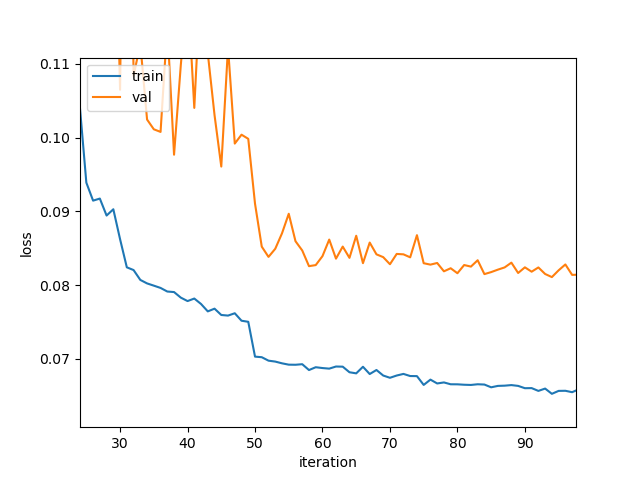

Text(0, 0.5, 'loss')

In [39]:
fig0, ax0 = plt.subplots()
ax0.plot(trace.history['loss'], '-')
ax0.plot(trace.history['val_loss'], '-')
ax0.legend(['train', 'val'], loc='upper left')
ax0.set_xlabel('iteration')
ax0.set_ylabel('loss')

In [40]:
# estimates = model.predict(x_train[0:100:16])
# print(estimates)
# print(y_train[0:100:16])
estimates = model.predict(x_test[:10]) #* 10
print("estimated translation x y z")
print(estimates)
print("actual translation x y z")
print(y_test[:10])

err = y_test[:10] - estimates
# err = y_train[0:100:16] - estimates

print("\n Error \n",err)

print(tf.math.reduce_mean(tf.math.reduce_sum(err, axis = 1)))




1/1 [==============================] - 0s 119ms/step
estimated translation x y z
[[-0.2557883  -1.1859785   0.01315598]
 [ 0.05737759 -0.0337988  -0.06353926]
 [-0.37487674  0.11650999  0.03844092]
 [-2.9121315   1.1515542   0.02515323]
 [ 2.5382843  -0.5279454   0.05638795]
 [-0.69203913 -0.33328462  0.00407009]
 [-1.5870426   1.0781376   0.02788126]
 [ 1.5838048  -0.24891533  0.05312932]
 [ 0.29480052  0.11943632  0.05216929]
 [ 0.12566529  0.8042189   0.00868105]]
actual translation x y z
[[-0.39774525 -1.1682906   0.03643715]
 [ 0.01352176 -0.03802298 -0.0869871 ]
 [-0.33941567  0.1537352   0.00907855]
 [-3.1164887   1.239107    0.00449022]
 [ 1.9535191  -0.96431375  0.08626982]
 [-0.6438517  -0.32707307 -0.06933241]
 [-1.6409906   1.0403774   0.08405025]
 [ 1.2478206  -0.3614935   0.06632768]
 [ 0.37182927  0.3661386  -0.05918126]
 [ 0.03899135  0.70835257 -0.12612954]]

 Error 
 [[-0.14195696  0.01768792  0.02328116]
 [-0.04385583 -0.00422418 -0.02344784]
 [ 0.03546107  0.0372252

In [18]:
%%latex
$$
\begin{aligned}
& \text {Table 1.1. Performance on Normalized Training Data }\\
&\begin{array}{cccc}
\hline \hline \text { } & \text { Mean Absolute Error } & \text { Batch Size } & \text { Epochs } & \text {Notes} \\
\hline 
\text{Scaled and Zeroed} & 0.6297 & 4096 & 10 & \text {asdf } \\
- & - & - & - \\
- & - & - & - \\
\hline
\end{array}
\end{aligned}
$$

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


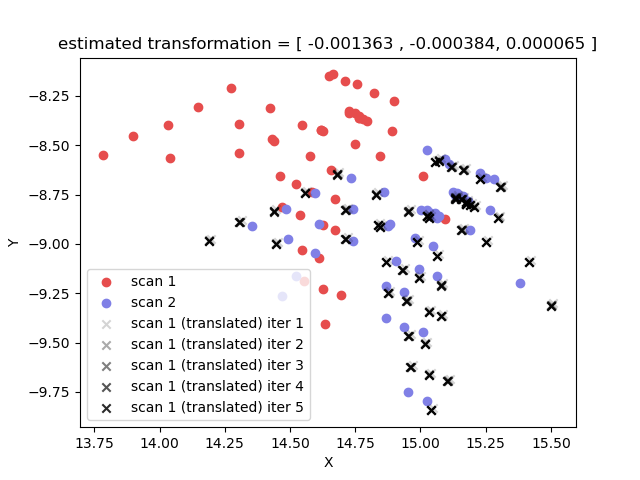

n =  157
1/1 [==============================] - 0s 11ms/step

 correct soln [ 0.38022554 -0.43848482  0.13766883]

 estiamted soln: [[ 0.40701635 -0.43740738  0.13077819]]

 error from DNN: [[-0.02679081 -0.00107744  0.00689064]]

 error in means [ 0.00697458 -0.0565888   0.00964664]


In [43]:
#visualize results of network on test data
#2d plots (x and y only)
fig1, ax1 = plt.subplots()
n = int(np.floor(500*np.random.rand()))
# n = 8 #sample number (from x_test)

print("n = ", n)

# print(tf.shape(x_test))
# c1 = np.array([x_test[n,:points_per_sample,0].numpy(), x_test[n,:points_per_sample,1].numpy(), x_test[n,:points_per_sample,2].numpy()])
# c2 = np.array([x_test[n,points_per_sample:,0].numpy(), x_test[n,points_per_sample:,1].numpy(), x_test[n,points_per_sample:,2].numpy()])
c1 = np.array([x_test[n,:points_per_sample,0], x_test[n,:points_per_sample,1], x_test[n,:points_per_sample,2]])
c2 = np.array([x_test[n,points_per_sample:(points_per_sample*2),0], x_test[n,points_per_sample:(points_per_sample*2),1], x_test[n,points_per_sample:(points_per_sample*2),2]])
ax1.scatter(c1[0,:], c1[1,:], color = [0.9, 0.3, 0.3], label = 'scan 1')
ax1.scatter(c2[0,:], c2[1,:], color = [0.5, 0.5, 0.9], label = 'scan 2')


inputs = x_test[n][None,:]
# print(x_test[n, 100:])
runlen = 5
corr_sum = np.zeros([1,3]) #init var to store correction contributions
for i in range(runlen):
    correction = model.predict(inputs)[0] #show what the network thinks
#     correction = correction*0.1
#     correction = y_test[n] #show actual solution
    corr_sum += correction
#     print(correction)
    c1 = np.array([c1[0,:] + correction[0], c1[1,:] + correction[1], c1[2,:] + correction[2]])
    inputs = np.append(c1, c2, axis = 1).T[None,:,:]
#     print(tf.shape(inputs))
#     print(tf.shape(x_test[n,None,100:]))
    inputs = np.append(inputs, x_test[n,None,2*points_per_sample:], axis = 1)
    moved = ax1.scatter(c1[0,:], c1[1,:], marker = 'x', color = [0., 0., 0., (i+1)/(runlen+1)],
                        label = 'scan 1 (translated) iter %i' %(i+1))

# moved = ax1.scatter(c1[0,:], c1[1,:], marker = 'x', color = [0.9, 0.3, 0.3, (i+2)/(runlen+2)],
#                         label = 'scan 1 (translated)')

ax1.set_title("estimated transformation = [ %f , %f, %f ]" %(correction[0], correction[1], correction[2]))
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.legend(loc = 'best')

print("\n correct soln", y_test[n])
# print("\n y_test", y_test[n]*0.1)
print("\n estiamted soln:", corr_sum)
print("\n error from DNN:", y_test[n] - corr_sum)
print("\n error in means",  y_test[n] + (np.mean(x_test[n,:points_per_sample], axis = 0) - 
      np.mean(x_test[n,points_per_sample:], axis = 0)))

In [44]:
#use Vedo to plot inital and transformed point clouds in 3D 
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget

plt1 = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True)
disp = []

#draw scan1 
# disp.append(Points(x_test[n,:points_per_sample].numpy(), c = 'green', r = 5))
disp.append(Points(x_test[n,:points_per_sample], c = 'green', r = 5))

#draw initial scan2
# disp.append(Points(x_test[n,points_per_sample:].numpy(), c = 'red', r = 5))
disp.append(Points(x_test[n,points_per_sample:points_per_sample*2], c = 'red', r = 5))

#draw transformed scan2
disp.append(Points(c1, c = 'blue', r = 5))

plt1.show(disp, "Network Performance Test")
ViewInteractiveWidget(plt1.window)



ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1397)

In [ ]:
#save network
# model.save("ffnet10k25.kmod")
# model.save("Net.kmod")
# model.save("PIPEnet10.kmod")
# model.save("KITTInet.kmod")
# model.save("FordNet.kmod")
# model.save("FordNetV3.kmod")
# model.save("FordNetCP.kmod")

#load network
# model = tf.keras.models.load_model("Net.kmod")
# model = tf.keras.models.load_model("FordNet.kmod")
# model = tf.keras.models.load_model("PIPEnet10.kmod")
# model = tf.keras.models.load_model("KITTInet.kmod")
# model = tf.keras.models.load_model("FORDNetV3.kmod")

In [ ]:
#test random shuffle layer to enforce training on unordered data
#GOAL: randomize order of each sample in batch SEPRATELY 
#      (i.e. don't have same order for all elements of batch)

test = tf.constant([[1., 3., 4.], [2., 3., 5.], [6., 6., 6.], [0., 0., 0.]])#[None, :, :]
test = tf.Variable([test, 2*test])
print(test)

test = tf.transpose(test, [1,0,2])
test = tf.random.shuffle(test)
test = tf.transpose(test, [1,0,2])
print(test)

### Top scores:

#### 1k dataset
8.23 MSE with no parallelization (vel = [5, 5, 5])

4.2 MSE (vel = [5, 5, 0.01])

3.9 MSE - 50 sample points from each scan

3.34- maxpool on first/ second half, conv after


#### 10k dataset

2.4 MSE 50 samples

1.05 MSE 25 samples -ffNet10k25.kmod

### KITTI drive 005, 100 frames

0.145 - Permnet

0.0895 -PCRnet

0.0520 KITTInet (5/20)

### KITTI drive 005, 150 frames, 50 sample points
0.759 pipeNET

### Ford Campus Drive 01 (200 frame sample)
0.073 - NET, 200 frames, with ground plane

### KITTI Full 00 400 frames, with ground plane
0.0752 net

### KITTI Full 00 400 frames, no ground plane
0.0756

### KITTI Full 00 4500 frames, with ground plane
0.0736 net


### Notes
From PointNet: Small rotations and gaussian noise can successfully augment models to increase training dataset

Need to figure out a way to achieve permutation invariance
Try transformer network i.e. "Attention is all you need"
https://ai.googleblog.com/2021/11/permutation-invariant-neural-networks.html

Can potentially use reflectance as 4th dimension(?)

### Find average error in mean point locations when ground truth solution is applied
Test for indexing when geterating training data using Ford dataset - this error should be minimal when we are correctly indexing gt

In [ ]:
d1 = np.loadtxt('training_data/ICET_Ford_scan1.txt') #available in repo
d2 = np.loadtxt('training_data/ICET_Ford_scan2.txt')
truth = np.loadtxt('training_data/ICET_Ford_ground_truth.txt')

points_per_sample = 50 #25 #50  #num pts per scan - defined in MatLab script
s1 = tf.reshape(tf.convert_to_tensor(d1), [-1, points_per_sample, 3])
s2 = tf.reshape(tf.convert_to_tensor(d2), [-1, points_per_sample, 3])
truth = tf.convert_to_tensor(truth)

In [ ]:
print(tf.shape(s1))
mu1 = tf.math.reduce_mean(s1, axis = 1)
mu2 = tf.math.reduce_mean(s2, axis = 1)
# print("\n mu1", mu1)
# print("\n mu2", mu2)
centers_error = mu1 - mu2 + truth 
# print("\n centers_error", centers_error)

#get mean absolute centers error across all voxels
# mace = tf.math.reduce_mean(abs(centers_error), axis = 0) #absolute error
mace = tf.math.reduce_mean(centers_error, axis = 0)
print("\n mace", mace)